In [3]:
from itertools import compress
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import h5py
from scipy import interpolate
import math
import optuna

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, GridSearchCV
# from pyriemann.estimation import XdawnCovariances
# from pyriemann.classification import MDM
import pyriemann
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.covariance import LedoitWolf
from sklearn.utils import resample
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer

from mne.decoding import UnsupervisedSpatialFilter, SlidingEstimator
from mne.preprocessing.nirs import optical_density, beer_lambert_law, scalp_coupling_index, temporal_derivative_distribution_repair
from mne_nirs.channels import get_long_channels, get_short_channels
from mne_nirs.channels import picks_pair_to_idx as p2idx
from mne_nirs.signal_enhancement import (enhance_negative_correlation,
                                         short_channel_regression)
from mne.viz import plot_compare_evokeds
from mne_nirs.experimental_design import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix

import mne
from mne.decoding import Scaler, cross_val_multiscore, Vectorizer
from mne import Epochs, events_from_annotations, set_log_level

from mne_nirs.io.snirf import write_raw_snirf
from mne_bids import write_raw_bids, BIDSPath, read_raw_bids

import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import cross_val_score, StratifiedKFold

import time


In [1]:
def normalize(raw_haemo,epochs):
    hold_data_all = epochs["1.0"].average() # take the average of breath holds for this subject
    hold_data_all = hold_data_all.get_data() # get the data

    max_during_hold = np.max(hold_data_all) # this should be a 1 x num_channels array

    print("max_during_hold: ", max_during_hold.shape)

    z = raw_haemo.get_data() # extract (only long channel) data from oxy and deoxy-hemoglobin concentration matrix
    z = np.transpose(z) / max_during_hold # Divide all traces in each channel by the maximum change in concentration during the breath hold.

    # We are now in arbitrary units (deltaHb / deltaHb)
    raw_haemo._data= np.transpose(z) # replace the data in raw_haemo

    return raw_haemo, epochs

In [7]:
raw_haemo, epochs = normalize(raw_haemo,epochs)

max_during_hold:  ()


In [4]:

def individual_analysis(bids_path):
    # Read data with annotations in BIDS format
    raw_intensity = read_raw_bids(bids_path, verbose=False)

    # Convert signal to optical density and determine bad channels
    raw_od = optical_density(raw_intensity)
    sci = scalp_coupling_index(raw_od, h_freq=1.35, h_trans_bandwidth=0.1)
    raw_od.info["bads"] = list(compress(raw_od.ch_names, sci < 0.5))
    raw_od.interpolate_bads()

    # Downsample and apply signal cleaning techniques
    raw_od.resample(1)
    raw_od = temporal_derivative_distribution_repair(raw_od)
    raw_od = short_channel_regression(raw_od)

    # Convert to haemoglobin and filter
    raw_haemo = beer_lambert_law(raw_od)
    
    ## FILTERS OUT HEART RATE
    raw_haemo = raw_haemo.filter(None, 0.4,
                                 h_trans_bandwidth=0.1, l_trans_bandwidth=0.01,
                                 verbose=False)
    raw_haemo.annotations.delete(raw_haemo.annotations.description == '15')
    
    # Apply further data cleaning techniques and extract epochs
    raw_haemo = enhance_negative_correlation(raw_haemo)

    # raw_haemo = get_long_channels(raw_haemo, min_dist=0.01)

    # Pick data channels that are actually informative
    roi_channels = mne.pick_channels(raw_haemo.info['ch_names'], include=['Left_PT','Right_PT'])
    raw_haemo = raw_haemo.copy().pick_channels(roi_channels)

    # Extract events but ignore those with
    events, event_dict = events_from_annotations(raw_haemo, verbose=False,
                                                 regexp='^(?![Ends]).*$')

    epochs = Epochs(raw_haemo, events, event_id=event_dict, tmin=-5, tmax=30,
                    reject=dict(hbo=100e-6), reject_by_annotation=True,
                    proj=True, baseline=(None, 0), detrend=1,
                    preload=True, verbose=False,event_repeated='merge')
    
    raw_haemo, epochs = normalize(raw_haemo,epochs)

    return raw_haemo, epochs

 

C:\Users\dalto\Downloads\project\sourcedata_lm\sub-01\nirs
Loading C:\Users\dalto\Downloads\project\sourcedata_lm\sub-01\nirs\sub-01_task-task_nirs.snirf


Used Annotations descriptions: ['1.0', '15.0', '2.0']
Reading 0 ... 5829  =      0.000 ...  1145.981 secs...
Interpolating bad channels
    Automatic origin fit: head of radius 90.8 mm
max_during_hold:  ()
C:\Users\dalto\Downloads\project\sourcedata_lm\sub-02\nirs
Loading C:\Users\dalto\Downloads\project\sourcedata_lm\sub-02\nirs\sub-02_task-task_nirs.snirf
Used Annotations descriptions: ['1.0', '15.0', '2.0']
Reading 0 ... 6250  =      0.000 ...  1228.750 secs...
Interpolating bad channels
    Automatic origin fit: head of radius 90.8 mm
max_during_hold:  ()

x_all.shape: (79, 92, 36)


y_all.shape: (79,)


Channel type fnirs finished rendering!

C:\Users\dalto\Downloads\project\sourcedata_lm\sub-01\nirs
Loading C:\Users\dalto\Downloads\project\sourcedata_lm\sub-01\nirs\sub-01_task-task_nirs.snirf
Used Annotations descriptions: ['1.0', '15.0', '2.0']
Reading 0 ... 5829  =      0.000 ...  1145.981 secs...
Interpolating bad channels
    Automatic origin fit: head of radius 90.8 mm
max_d

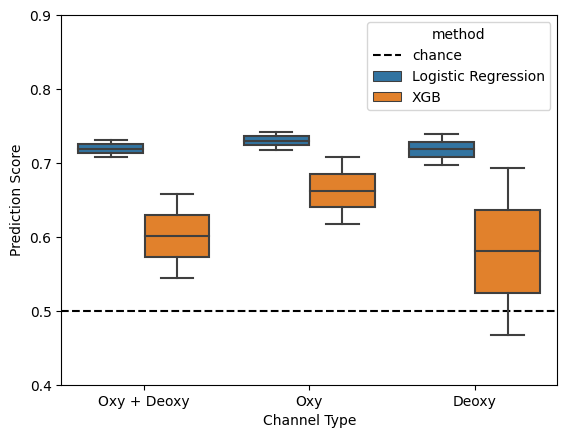

In [6]:
all_evokeds = defaultdict(list)
total_time = 0

scores = []
st_scores = []  # spatio-temporal scores
sliding_scores = []  # sliding scores
weird_subs = []
weird_count = 0

hbo_all = []
hbo_epochs = []
hbr_all = []
hbr_epochs = []
gsr_all = []
gsr_epochs = []
fused_epochs = []
event_dict = {}
fused_events = []
appended = False
save = False
union_scores = []
dn_scores = []
morning = True 
sub_iter = 0
morn_scores = pd.DataFrame()
aft_scores = pd.DataFrame()
oxy_hbo_conv = {'hbo': 'Oxy', 'hbr': 'Deoxy','fnirs': 'Oxy + Deoxy'}
ch_list = []

nsubs = 2

logreg = LogisticRegression(solver='liblinear',max_iter=500)
xg = xgb.XGBClassifier(booster='gblinear', objective='binary:logistic', eval_metric='auc', n_jobs=-1, verbosity=0, n_estimators=50, eta=.3)
knn = KNN(n_neighbors=20)
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)


for ch_type in ["fnirs", "hbo", "hbr"]:
# for ch_type in ["hbo"]:
    x_all = []
    y_all = []
    groups = []

    for sub in range(1,nsubs+1):
        subject_id = "%02d" % sub
        bids_path = BIDSPath(
            subject="%02d" % sub,
            task="task",
            # session='01',
            datatype="nirs",
            suffix='nirs',
            root=r"C:\Users\dalto\Downloads\project\sourcedata_lm",
            extension=".snirf"
        )

        # Read source data
        fname = str(bids_path.directory)
        print(fname)
        snirf_path = bids_path
        raw = mne.io.read_raw_snirf(snirf_path, preload=False)
        raw.info["line_freq"] = 50  # specify line frequency as required by BIDS
        events, event_id = mne.events_from_annotations(raw)

        raw_haemo, epochs = individual_analysis(bids_path)

        # get haemo channel epochs
        epochs = epochs[["1.0", "2.0"]].pick(ch_type)
        
        # set x and y training data
        x = epochs.get_data()
        y = epochs.events[:, 2]

        #swap all values of '3' in y to '0'
        y = np.where(y == 3, 0, y)

        if ch_type == 'hbo':
            hbo_all.append(x)
            hbo_epochs.append(epochs)
            save = True

            if appended != True:
                fused_events.append(events)
                fused_events.append(events)
                appended = False

            if len(x) < 40:
                weird_subs.append(sub)
                # if sub not in weird_subs[:]:
                weird_count = weird_count + 1

        if ch_type == 'hbr':
            hbr_all.append(x)
            hbr_epochs.append(epochs)
            save = True

        # appending arrays
        x_all.append(x)
        y_all.append(y)
        groups.append(sub * np.ones(len(x)))       

    tod_list = ['Morning' if i % 2 == 0 else 'Afternoon' for i in range(nsubs)]
    tod_list = np.array(tod_list)

    # do across subjects decoding (leave one subject out)
    x_all = np.concatenate(x_all, axis=0)
    y_all = np.concatenate(y_all, axis=0)
    groups = np.concatenate(groups, axis=0)

    print(f"\nx_all.shape: {x_all.shape}\n")
    print(f"\ny_all.shape: {y_all.shape}\n")

    print(f"\nChannel type {ch_type} finished rendering!\n")

    
    clf = make_pipeline(
        Scaler(epochs.info), 
        Vectorizer(), 
        LogisticRegression()
    ) 

    st_scores = cross_val_multiscore(
        clf,
        x_all,
        y_all,
        cv=LeaveOneGroupOut(),
        groups=groups,
        n_jobs=1,
        scoring="roc_auc",
    )

    ch_list = [oxy_hbo_conv[ch_type]] * nsubs

    scores.append(
        pd.DataFrame({"Prediction Score": st_scores, "method": "Logistic Regression", "Channel Type": oxy_hbo_conv[ch_type],"Time of Day": tod_list})
    )

    if save == True:
        union_scores.append(
            pd.DataFrame({"Prediction Score": st_scores, "method": "Logistic Regression", "Channel Type": oxy_hbo_conv[ch_type],"Time of Day": tod_list})
        )

    
    
    # start timing the loop
    start_time = time.time()
    
    clf = make_pipeline(
        Scaler(epochs.info), 
        Vectorizer(), 
        xg)

    xgb_scores = cross_val_multiscore(
        clf,
        x_all,
        y_all,
        cv=LeaveOneGroupOut(),
        groups=groups,
        n_jobs=1,
        scoring="roc_auc",
    )

    scores.append(
        pd.DataFrame({"Prediction Score": xgb_scores, "method": "XGB", "Channel Type": oxy_hbo_conv[ch_type],"Time of Day": tod_list})
    )

    if save == True:
        union_scores.append(
            pd.DataFrame({"Prediction Score": xgb_scores, "method": "XGB", "Channel Type": oxy_hbo_conv[ch_type],"Time of Day": tod_list})
        )

        if morning == True:
            dn_scores.append(
                pd.DataFrame({"Prediction Score": xgb_scores, "method": "XGB", "Time of Day": "Morning"}))
        else:
            dn_scores.append(
                pd.DataFrame({"Prediction Score": xgb_scores, "method": "XGB", "Time of Day": "Afternoon"}))
            
    end_time = time.time() - start_time
    total_time += end_time

    save = False

print(f"total_time: {total_time}\n")

scores = pd.concat(scores, ignore_index=True)

plt.clf()
plt.axhline(0.5, linestyle='--', color='k', label="chance")
plt.ylim(.4, .9)
sns.boxplot(x="Channel Type", y="Prediction Score", hue="method", data=scores)
plt.show()
# dn_scores = pd.concat(dn_scores, ignore_index=True)

In [164]:
print(scores)

    Prediction Score               method Channel Type Time of Day
0           0.792105  Logistic Regression  Oxy + Deoxy     Morning
1           0.490000  Logistic Regression  Oxy + Deoxy   Afternoon
2           0.797500  Logistic Regression  Oxy + Deoxy     Morning
3           0.830000  Logistic Regression  Oxy + Deoxy   Afternoon
4           0.767500  Logistic Regression  Oxy + Deoxy     Morning
5           0.663158  Logistic Regression  Oxy + Deoxy   Afternoon
6           0.668421  Logistic Regression  Oxy + Deoxy     Morning
7           0.707500  Logistic Regression  Oxy + Deoxy   Afternoon
8           0.747500  Logistic Regression  Oxy + Deoxy     Morning
9           0.676316  Logistic Regression  Oxy + Deoxy   Afternoon
10          0.785526                  XGB  Oxy + Deoxy     Morning
11          0.530000                  XGB  Oxy + Deoxy   Afternoon
12          0.727500                  XGB  Oxy + Deoxy     Morning
13          0.796250                  XGB  Oxy + Deoxy   After

In [165]:
avg_log = scores[scores['method'] == 'Logistic Regression'].groupby(['Channel Type']).median()
avg_xgb = scores[scores['method'] == 'XGB'].groupby(['Channel Type']).median()

# print(f'avg_log: {avg_log}\navg_xgb: {avg_xgb}')
display(avg_log)
display(avg_xgb)

C:\Users\dalto\AppData\Local\Temp\ipykernel_17704\3051180233.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_log = scores[scores['method'] == 'Logistic Regression'].groupby(['Channel Type']).median()
C:\Users\dalto\AppData\Local\Temp\ipykernel_17704\3051180233.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_xgb = scores[scores['method'] == 'XGB'].groupby(['Channel Type']).median()


,Prediction Score
Channel Type,
Deoxy,0.7250
Oxy,0.7250
Oxy + Deoxy,0.7275


,Prediction Score
Channel Type,
Deoxy,0.700789
Oxy,0.668487
Oxy + Deoxy,0.705000


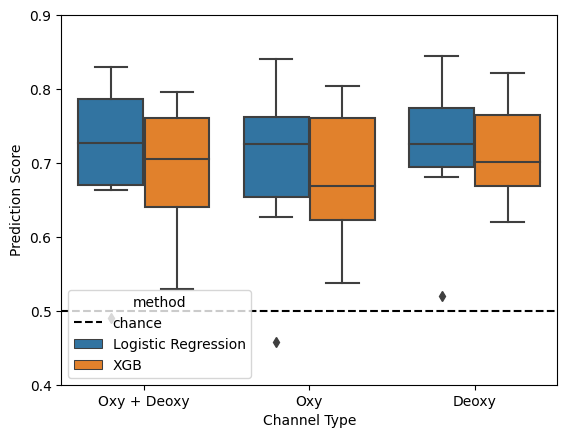

In [166]:
plt.clf()
plt.axhline(0.5, linestyle='--', color='k', label="chance")
plt.ylim(.4, .9)
sns.boxplot(x="Channel Type", y="Prediction Score", hue="method", data=scores)
plt.show()

In [182]:
def learn(ch_type):
    aux_clf = make_pipeline(
        Scaler(aux_epochs.info), 
        Vectorizer(), logreg
    )

    aux_st_scores = cross_val_score(
        aux_clf,
        aux_x_all,
        aux_y_all,
        cv=kfold,
        groups=aux_groups,
        n_jobs=1,
        scoring="roc_auc",
    )

    aux_scores.append(
        pd.DataFrame({"Prediction Score": aux_st_scores, "method":"Basic","Channel Type": ch_type})
    )

In [183]:
ch_names = ["Resp.", "PPG", "Sp02", "HR", "GSR", "Temp."]
aux_scores = []
physio_x = []
physio_y = []
physio_groups = []

hr_all = []
resp_all = []
temp_all = []
ppg_all = []
sp_all = []

hr_epochs = []
resp_epochs = []
temp_epochs = []
ppg_epochs = []
sp_epochs = []

all_physio = pd.DataFrame()

for ch_type in ch_names:
# for ch_type in ['GSR']:
    aux_x_all = []
    aux_y_all = []
    aux_groups = []
    for sub in range(1,nsubs+1):
        subject_id = "%02d" % sub
        bids_path = BIDSPath(
            subject="%02d" % sub,
            task="wings",
            session='01',
            datatype="nirs",
            suffix='nirs',
            root=r"C:\Users\dalto\Downloads\project\sourcedata_lm",
            extension=".snirf"
        )

        # bids_path = r"C:\Users\dalto\Downloads\sub-00\sub-00\2023-07-18_001\2023-07-18_001.snirf"

        raw_haemo = beer_lambert_law(optical_density(read_raw_snirf(bids_path)))
        raw_haemo = raw_haemo.filter(None, 0.4,
                                 h_trans_bandwidth=0.1, l_trans_bandwidth=0.01,
                                 verbose=False)
        raw_haemo.annotations.delete(raw_haemo.annotations.description == '15')
        raw_haemo = enhance_negative_correlation(raw_haemo)

        ##### PHYSIO PHOOLERY #####
        # Specify number of physio channels you're using
        n_samples = 6

        # Create a new 2D array to store the results
        result_array = np.empty((len(range(18, 24)), n_samples))  # Replace `n_samples` with the appropriate number

        result_list = []
        # Loop over values of n from 18 to 24
        for i, n in enumerate(range(18, 24)):
            aux_data_match = None  # Initialize aux_data_match variable
            dat = h5py.File(bids_path, 'r')
            aux = np.array(dat.get(f'nirs/aux{n}/dataTimeSeries'))
            aux_time = np.array(dat.get(f'nirs/aux{n}/time'))
            aux_data_interp = interpolate.interp1d(aux_time, aux, axis=0, bounds_error=False, fill_value='extrapolate')
            aux_data_match = aux_data_interp(raw_haemo.times)

            # Append aux_data_match to the result list
            result_list.append(aux_data_match)

        # Convert the list to a 2D array
        result_array = np.array(result_list)
        # print(f"\n\nresult_array: {result_array.mean().shape}\n")

        #### INIT INFO  ####
        sfreq = 1   # sampling data at 1 Hz
        ch_types = ["hbr"] * n_samples
        info = mne.create_info(ch_names,ch_types=ch_types, sfreq=sfreq)


        ####  INIT RAW  ####
        data = aux_data_match
        simulated_raw = mne.io.RawArray(result_array, info).pick(ch_type)
        # simulated_raw.plot(show_scrollbars=False, show_scalebars=False)

        #### INITIALIZE EPOCH ####
        raw_haemo.annotations.delete(raw_haemo.annotations.description == '15')
        events, event_dict = events_from_annotations(raw_haemo, verbose=False,
                                                        regexp='^(?![Ends]).*$')
        
        # print(f"\nevents:\n{events}\n")

        aux_epochs = Epochs(simulated_raw, events, event_id=event_dict, tmin=-5, tmax=30,
                        reject_by_annotation=True,
                        proj=True, baseline=(None, 0), detrend=1,
                        preload=True, verbose=False,event_repeated='merge')

        aux_x = aux_epochs.get_data()
        aux_y = aux_epochs.events[:, 2]

        # print(f"\n\naux_x_all: {aux_x}\n")
        # print(f"\n\naux_y_all: {aux_y}\n")

        aux_x_all.append(aux_x)
        aux_y_all.append(aux_y)
        aux_groups.append(sub * np.ones(len(aux_x))) 

        
        if ch_type == 'GSR':
            print(f"\nweird_count: {weird_count}\n")
            print(f"\nweird_subs: {weird_subs}\n")
            if sub in weird_subs:
                aux_x = aux_x[:-1]
                aux_y = aux_y[:-1]

            gsr_all.append(aux_x)
            gsr_epochs.append(aux_epochs)

        if ch_type == 'HR':
            print(f"\nweird_count: {weird_count}\n")
            print(f"\nweird_subs: {weird_subs}\n")
            if sub in weird_subs:
                aux_x = aux_x[:-1]
                aux_y = aux_y[:-1]
            hr_all.append(aux_x)
            hr_epochs.append(aux_epochs)

        if ch_type == 'Resp.':
            print(f"\nweird_count: {weird_count}\n")
            print(f"\nweird_subs: {weird_subs}\n")
            if sub in weird_subs:
                aux_x = aux_x[:-1]
                aux_y = aux_y[:-1]
            resp_all.append(aux_x)
            resp_epochs.append(aux_epochs)

        if ch_type == 'Temp.':
            print(f"\nweird_count: {weird_count}\n")
            print(f"\nweird_subs: {weird_subs}\n")
            if sub in weird_subs:
                aux_x = aux_x[:-1]
                aux_y = aux_y[:-1]
            temp_all.append(aux_x)
            temp_epochs.append(aux_epochs)

        if ch_type == 'PPG':
            print(f"\nweird_count: {weird_count}\n")
            print(f"\nweird_subs: {weird_subs}\n")
            if sub in weird_subs:
                aux_x = aux_x[:-1]
                aux_y = aux_y[:-1]
            ppg_all.append(aux_x)
            ppg_epochs.append(aux_epochs)

        if ch_type == 'Sp02':
            print(f"\nweird_count: {weird_count}\n")
            print(f"\nweird_subs: {weird_subs}\n")
            if sub in weird_subs:
                aux_x = aux_x[:-1]
                aux_y = aux_y[:-1]
            sp_all.append(aux_x)
            sp_epochs.append(aux_epochs)


    aux_x_all = np.concatenate(aux_x_all,axis=0)
    aux_y_all = np.concatenate(aux_y_all,axis=0)
    aux_groups = np.concatenate(aux_groups,axis=0)

    physio_x.append(aux_x_all)
    physio_y.append(aux_y_all)
    physio_groups.append(sub * np.ones(len(aux_x_all)))

    
    print(f"\naux_x_all shape:{aux_x_all.shape}\n")
    print(f"\naux_y_all shape:{aux_y_all.shape}\n")

    # for ch_type in ch_names:
    learn(ch_type)
# scores = pd.concat(scores, axis=0)

physio_x = np.concatenate(physio_x,axis=0)
physio_y = np.concatenate(physio_y,axis=0)
physio_groups = np.concatenate(physio_groups,axis=0)

print(f"\naux_scores:\n{aux_scores}\n")

# aux_scores = pd.concat(aux_scores, ignore_index=True)

Loading C:\Users\dalto\Downloads\project\sourcedata_lm\sub-01\ses-01\nirs\sub-01_ses-01_task-wings_nirs.snirf


Reading 0 ... 5829  =      0.000 ...  1145.981 secs...
Creating RawArray with float64 data, n_channels=6, n_times=5830
    Range : 0 ... 5829 =      0.000 ...  5829.000 secs
Ready.

weird_count: 4


weird_subs: [1, 6, 7, 10]

Loading C:\Users\dalto\Downloads\project\sourcedata_lm\sub-02\ses-01\nirs\sub-02_ses-01_task-wings_nirs.snirf
Reading 0 ... 6250  =      0.000 ...  1228.750 secs...
Creating RawArray with float64 data, n_channels=6, n_times=6251
    Range : 0 ... 6250 =      0.000 ...  6250.000 secs
Ready.

weird_count: 4


weird_subs: [1, 6, 7, 10]

Loading C:\Users\dalto\Downloads\project\sourcedata_lm\sub-03\ses-01\nirs\sub-03_ses-01_task-wings_nirs.snirf
Reading 0 ... 6022  =      0.000 ...  1183.925 secs...
Creating RawArray with float64 data, n_channels=6, n_times=6023
    Range : 0 ... 6022 =      0.000 ...  6022.000 secs
Ready.

weird_count: 4


weird_subs: [1, 6, 7, 10]

Loading C:\Users\dalto\Downloads\project\sourcedata_lm\sub-04\ses-01\nirs\sub-04_ses-01_task-wings_nir

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [ ]:
physio_clf = make_pipeline(
    Scaler(aux_epochs.info), 
    Vectorizer(), xg
)

physio_st_scores = cross_val_score(
    physio_clf,
    physio_x,
    physio_y,
    cv=kfold,
    groups=physio_groups,
    n_jobs=1,
    scoring="roc_auc",
)

aux_scores.append(
    pd.DataFrame({"Prediction Score": physio_st_scores, "method":"Basic","Channel Type": "All Physio"}))

aux_scores = pd.concat(aux_scores, axis=0,ignore_index=True)

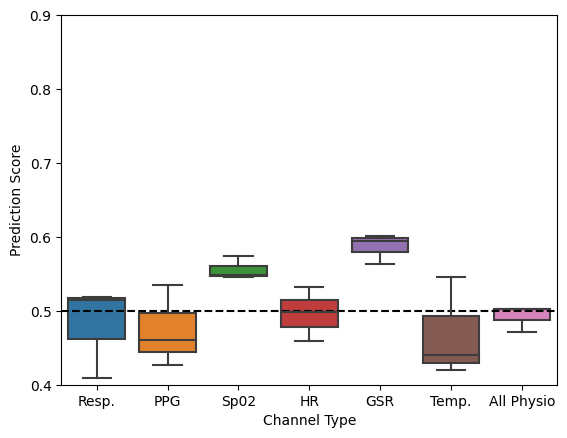

In [ ]:
plt.clf()
plt.axhline(0.5, linestyle='--', color='k', label="chance")
plt.ylim(.4, .9)
sns.boxplot(x="Channel Type", y="Prediction Score", data=aux_scores)
plt.show()

In [171]:
def extract_hbo_all(X):
    return X['hbo_all']

def extract_hbr_all(X):
    return X['hbr_all']

def extract_gsr_all(X):
    return X['gsr_all']

def extract_hr(X):
    return X['hr_all']

def extract_resp(X):
    return X['resp_all']

def extract_temp(X):
    return X['temp_all']

def extract_ppg(X):
    return X['ppg_all']

def extract_sp(X):
    return X['sp_all']

In [172]:
hbo_all = np.concatenate(hbo_all,axis=0)
hbr_all = np.concatenate(hbr_all,axis=0)
gsr_all = np.concatenate(gsr_all,axis=0)
hr_all = np.concatenate(hr_all,axis=0)
resp_all = np.concatenate(resp_all,axis=0)
temp_all = np.concatenate(temp_all,axis=0)
ppg_all = np.concatenate(ppg_all,axis=0)
sp_all = np.concatenate(sp_all,axis=0)

physio_all = physio_x

In [173]:
# Create a structured array
fused_all = np.empty((hbo_all.shape[0],), dtype=[('hbo_all', hbo_all.dtype, hbo_all.shape[1:]),
                            ('hbr_all', hbr_all.dtype, hbr_all.shape[1:]),
                            ('gsr_all', gsr_all.dtype, gsr_all.shape[1:]),
                            ('hr_all', hr_all.dtype, hr_all.shape[1:]),
                            ('resp_all', resp_all.dtype, resp_all.shape[1:]),
                            ('temp_all', temp_all.dtype, temp_all.shape[1:]),
                            ('ppg_all', ppg_all.dtype, ppg_all.shape[1:]),
                            ('sp_all', sp_all.dtype, sp_all.shape[1:])
                            ])

# Assign the arrays to the structured array
fused_all['hbo_all'] = hbo_all
fused_all['hbr_all'] = hbr_all
fused_all['gsr_all'] = gsr_all
fused_all['hr_all'] = hr_all
fused_all['resp_all'] = resp_all
fused_all['temp_all'] = temp_all
fused_all['ppg_all'] = ppg_all
fused_all['sp_all'] = sp_all

union_scores = pd.concat(union_scores, axis=0)


fused_all shape: (396, 46, 36)


fused_all shape: (396, 46, 36)


fused_all shape: (396, 46, 36)


fused_all shape: (396, 46, 36)


fused_all shape: (396, 46, 36)



C:\Users\dalto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\dalto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


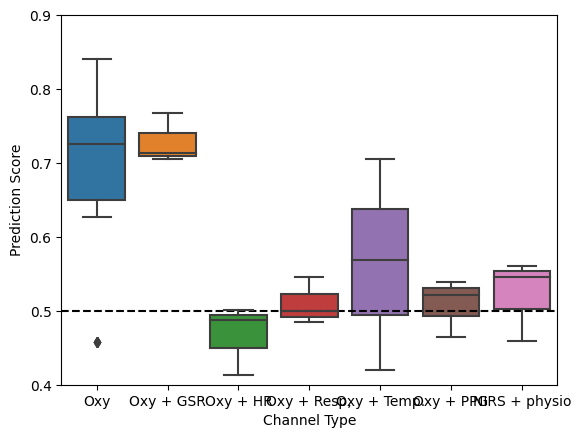


fused_all shape: (396, 46, 36)


fused_all shape: (396, 46, 36)


fused_all shape: (396, 46, 36)


fused_all shape: (396, 46, 36)


fused_all shape: (396, 46, 36)



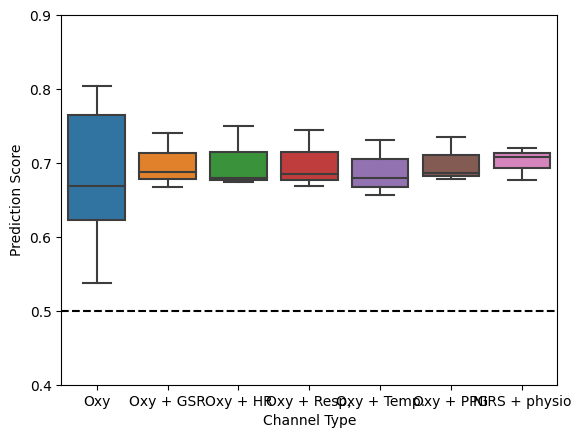


union_scores:
   Prediction Score               method Channel Type Time of Day
0          0.760526  Logistic Regression          Oxy     Morning
1          0.457500  Logistic Regression          Oxy   Afternoon
2          0.762500  Logistic Regression          Oxy     Morning
3          0.840000  Logistic Regression          Oxy   Afternoon
4          0.762500  Logistic Regression          Oxy     Morning
5          0.650000  Logistic Regression          Oxy   Afternoon
6          0.626316  Logistic Regression          Oxy     Morning
7          0.715000  Logistic Regression          Oxy   Afternoon
8          0.735000  Logistic Regression          Oxy     Morning
9          0.663158  Logistic Regression          Oxy   Afternoon
0          0.750000                  XGB          Oxy     Morning
1          0.537500                  XGB          Oxy   Afternoon
2          0.782500                  XGB          Oxy     Morning
3          0.803750                  XGB          Oxy   After

In [174]:
for model in [logreg,xg]:
    model_scores = []
    if model == logreg:
        model_name = 'Logistic Regression'
    if model == xg:
        model_name = 'XGB'

    # Create transformers for the sub-array extraction functions
    hbo_selector = FunctionTransformer(extract_hbo_all)
    hbr_selector = FunctionTransformer(extract_hbr_all)
    gsr_selector = FunctionTransformer(extract_gsr_all)
    resp_selector = FunctionTransformer(extract_resp)
    temp_selector = FunctionTransformer(extract_temp)
    ppg_selector = FunctionTransformer(extract_ppg)
    hr_sl_selector = FunctionTransformer(extract_hr)
    sp_selector = FunctionTransformer(extract_sp)

    col_trans = make_column_transformer(
                                        (Scaler(epochs.info), hbo_selector),
                                        (Scaler(epochs.info), hbr_selector),
                                        (Scaler(aux_epochs.info), gsr_selector),
                                        (Scaler(aux_epochs.info), hr_sl_selector),
                                        (Scaler(aux_epochs.info), resp_selector),
                                        (Scaler(aux_epochs.info), temp_selector),
                                        (Scaler(aux_epochs.info), ppg_selector),
                                        (Scaler(aux_epochs.info), sp_selector),
                                        remainder = 'drop')

    hbo_pipe = make_pipeline(hbo_selector,Scaler(epochs.info))
    hbr_pipe = make_pipeline(hbr_selector,Scaler(epochs.info))
    gsr_pipe = make_pipeline(gsr_selector,Scaler(aux_epochs.info))
    hr_pipe = make_pipeline(hr_sl_selector,Scaler(aux_epochs.info))
    resp_pipe = make_pipeline(resp_selector,Scaler(aux_epochs.info))
    temp_pipe = make_pipeline(temp_selector,Scaler(aux_epochs.info))
    ppg_pipe = make_pipeline(ppg_selector,Scaler(aux_epochs.info))
    sp_pipe = make_pipeline(sp_selector,Scaler(aux_epochs.info))
    # physio_pipe = make_pipeline(hbo_selector,gsr_selector,hr_sl_selector,Scaler(aux_epochs.info),Vectorizer(), model)


    for pipe,pipe_name in zip([gsr_pipe,hr_pipe,resp_pipe,temp_pipe,ppg_pipe],['GSR','HR', 'Resp,','Temp.','PPG']):
    # for pipe,pipe_name in zip([gsr_pipe,hr_pipe],['GSR','HR']):
        pipe_union = FeatureUnion([
            ('hbo', hbo_pipe),
            (pipe_name, pipe),
            ])

        pipe = make_pipeline(pipe_union, Vectorizer(), model)

        print(f"\nfused_all shape: {fused_all['hbo_all'].shape}\n")

        aux_st_scores = cross_val_multiscore(
            pipe,
            fused_all,
            y_all,
            cv=kfold,
            groups=groups,
            n_jobs=1,
            scoring="roc_auc"
        )
        
        # append the hbo scores for the given model from the union_scores dataframe
        model_scores.append(union_scores[(union_scores['Channel Type'] == 'Oxy') & (union_scores['method'] == model_name)])

        model_scores.append(
            pd.DataFrame({"Prediction Score": aux_st_scores, "method": model_name,"Channel Type": "Oxy + " + pipe_name})
        )

    physio_union = FeatureUnion([
            ('hbo', hbo_pipe),
            ('hbr', hbr_pipe),
            ('GSR', gsr_pipe),
            ('HR', hr_pipe),
            ('Resp', resp_pipe),
            ('Temp', temp_pipe),
            ('PPG', ppg_pipe),
            ])

    physio_pipe = make_pipeline(physio_union, Vectorizer(), model)


    aux_st_scores = cross_val_multiscore(
            physio_pipe,
            fused_all,
            y_all,
            cv=kfold,
            groups=groups,
            n_jobs=1,
            scoring="roc_auc"
        )
    
    model_scores.append(union_scores[(union_scores['Channel Type'] == 'Oxy') & (union_scores['method'] == model_name)])

    model_scores.append(
        pd.DataFrame({"Prediction Score": aux_st_scores, "method": model_name,"Channel Type": "NIRS + " + "physio"})
    )

    # print(model_name)
    # print(model)

    model_scores = pd.concat(model_scores, axis=0)

    plt.clf()
    plt.axhline(0.5, linestyle='--', color='k', label="chance")
    plt.ylim(.4, .9)
    sns.boxplot(x="Channel Type", y="Prediction Score",data=model_scores)
    plt.show()

print(f"\nmodel_scores:\n{model_scores}\n")

In [184]:
print(f"model scores:\n{model_scores}\n")

model scores:
    Prediction Score method   Channel Type Time of Day
0           0.750000    XGB            Oxy     Morning
1           0.537500    XGB            Oxy   Afternoon
2           0.782500    XGB            Oxy     Morning
3           0.803750    XGB            Oxy   Afternoon
4           0.765000    XGB            Oxy     Morning
..               ...    ...            ...         ...
8           0.697500    XGB            Oxy     Morning
9           0.639474    XGB            Oxy   Afternoon
0           0.677612    XGB  NIRS + physio         NaN
1           0.707759    XGB  NIRS + physio         NaN
2           0.719927    XGB  NIRS + physio         NaN

[78 rows x 4 columns]



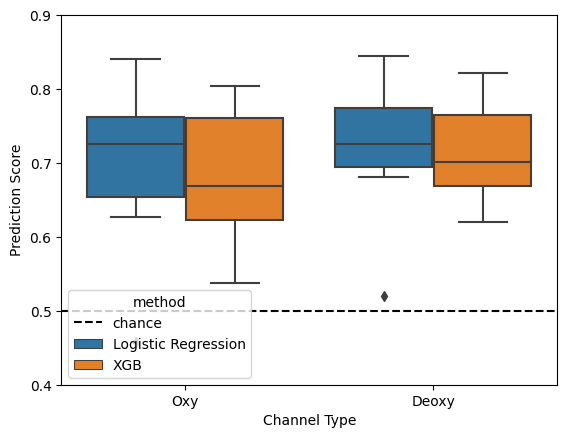

In [175]:
plt.clf()
plt.axhline(0.5, linestyle='--', color='k', label="chance")
plt.ylim(.4, .9)
sns.boxplot(x="Channel Type", y="Prediction Score", hue = 'method',data=union_scores)
plt.show()

In [176]:
# morn_scores = union_scores.iloc[::2].reset_index(drop=True)
print(len(union_scores))
# union_scores = pd.concat(union_scores, axis=0)
display(union_scores)

40


,Prediction Score,method,Channel Type,Time of Day
0,0.760526,Logistic Regression,Oxy,Morning
1,0.457500,Logistic Regression,Oxy,Afternoon
2,0.762500,Logistic Regression,Oxy,Morning
3,0.840000,Logistic Regression,Oxy,Afternoon
4,0.762500,Logistic Regression,Oxy,Morning
5,0.650000,Logistic Regression,Oxy,Afternoon
6,0.626316,Logistic Regression,Oxy,Morning
7,0.715000,Logistic Regression,Oxy,Afternoon
8,0.735000,Logistic Regression,Oxy,Morning
9,0.663158,Logistic Regression,Oxy,Afternoon


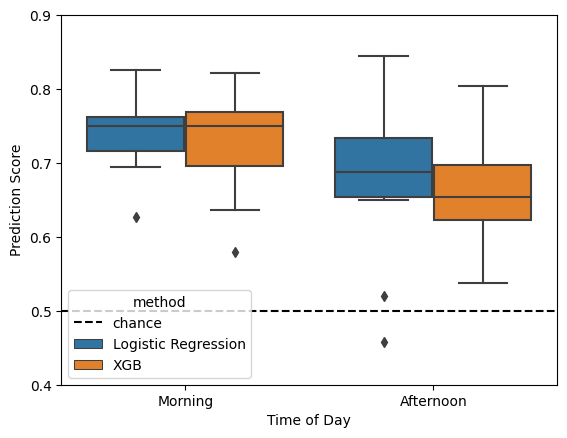

In [177]:
plt.clf()
plt.axhline(0.5, linestyle='--', color='k', label="chance")
plt.ylim(.4, .9)
sns.boxplot(x="Time of Day", y="Prediction Score", hue = 'method',data=union_scores)
plt.show()